Inspired in https://maelfabien.github.io/machinelearning/NLP_5/#concept

More advanced techniques: https://joeddav.github.io/blog/2020/05/29/ZSL.html

Much more advance (FUTURE WORK): https://medium.com/swlh/few-shot-learning-in-nlp-use-siamese-networks-189de22459d0

In [8]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import sys
import os
cwd = os.getcwd()
sys.path.insert(0, cwd + "/..")

In [10]:
from tqdm import tqdm
import matplotlib.pylab as plt
import numpy as np

# Loads a Dataset

In [11]:
from koala.utils import convert_to_samples

In [12]:
def balance_data(list_of_samples):
    labels, counts = np.unique([s.label for s in list_of_samples], return_counts=True)
    data_per_label = min(counts)
    counters = {l: 0 for l in labels}
    balanced_data = []
    for s in list_of_samples:
        if counters[s.label] == data_per_label:
            continue
        else:
            counters[s.label] = counters[s.label] + 1
            balanced_data.append(s)
    return balanced_data

In [16]:
from datasets import load_dataset
NAME_DATASET = 'ag_news'
def change_label(sample, dict_names):
    sample.label = dict_names[sample.label]
    return sample

if NAME_DATASET == "ag_news":
    dict_names_labels = {0: "world",
                        1: "sports",
                        2: "business",
                        3: "science/tech"}
    
    datasets = load_dataset('ag_news')
    dataset_train = datasets["train"]
    dataset_test = datasets["test"]
    train_samples = convert_to_samples(dataset_train)
    test_samples = convert_to_samples(dataset_test)
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
elif NAME_DATASET == "per_sent":
    dict_names_labels = {0: "negative",
                        1: "neutral",
                        2: "positive"}
    
    datasets = load_dataset("per_sent")
    # We echange test and train because test is not balanced and it's too small to be balanced
    dataset_train = datasets["test_random"]
    dataset_test = datasets["train"]
    
    train_samples = convert_to_samples(dataset_train, 'DOCUMENT', 'TRUE_SENTIMENT')
    test_samples = convert_to_samples(dataset_test,  'DOCUMENT', 'TRUE_SENTIMENT')
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
    test_samples = balance_data(test_samples)
elif NAME_DATASET == "hate_speech_offensive":
    dict_names_labels = {0: "hate_speech",
                    1: "offensive",
                    2: "neither"}
    
    datasets = load_dataset("hate_speech_offensive")
    dataset_train = datasets["train"].filter(lambda example, indice: indice < 1000, with_indices=True)
    dataset_test = datasets["train"].filter(lambda example, indice: 1000< indice, with_indices=True)
    
    train_samples = convert_to_samples(dataset_train, 'tweet', 'class')
    test_samples = convert_to_samples(dataset_test,  'tweet', 'class')
    train_samples = [change_label(s, dict_names_labels) for s in train_samples]
    
    test_samples = [change_label(s, dict_names_labels) for s in test_samples]
    test_samples = balance_data(test_samples)
elif NAME_DATASET == "yahoo_answers_topics":
    datasets = load_dataset("yahoo_answers_topics")
    dataset_train = datasets["train"].filter(lambda example, indice: indice < 1000, with_indices=True)
    dataset_test = datasets["test"].filter(lambda example, indice: indice < 2000, with_indices=True)
    train_samples = convert_to_samples(dataset_train, "question_title", "topic")
    test_samples = convert_to_samples(dataset_test,"question_title", "topic")
    test_samples = balance_data(test_samples)



Using custom data configuration default
Reusing dataset ag_news (/home/rodri/.cache/huggingface/datasets/ag_news/default/0.0.0/fb5c5e74a110037311ef5e904583ce9f8b9fbc1354290f97b4929f01b3f48b1a)


In [30]:
import random
test_samples = random.sample(test_samples, 500)
train_samples = random.sample(train_samples, 100)

In [31]:
print(len(train_samples), " for training")
print(len(test_samples), " for test")

100  for training
500  for test


In [32]:
labels = list(set([s.label for s in test_samples]))
print(labels)

['science/tech', 'world', 'sports', 'business']


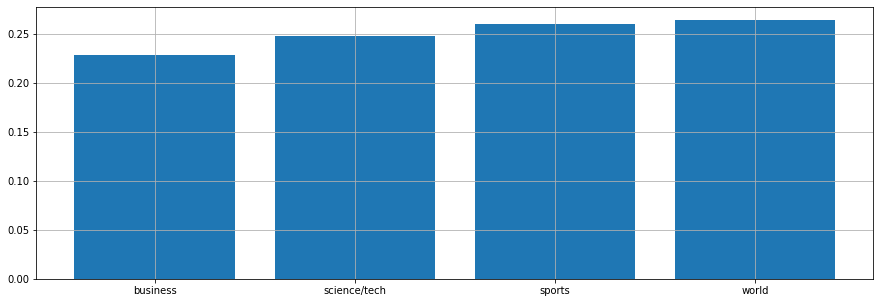

In [33]:

plt.figure(figsize=(15, 5))
labels, counts = np.unique([s.label for s in test_samples], return_counts=True)
norm_counts = counts / sum(counts)
plt.bar(labels, norm_counts);
plt.grid(True)

# Loads Encoder

In [34]:
from koala.encoders import Encoder

In [35]:
encoder = Encoder("en")

In [36]:
from tqdm import tqdm
for i in tqdm(range(len(test_samples))):
    s = test_samples[i]
    s.encode(encoder, keep_vector=True)
    test_samples[i] = s

100%|██████████| 500/500 [00:14<00:00, 34.20it/s]


# Visualization of the test data

In [37]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca = pca.fit([x.vector for x in test_samples])

In [38]:
reduced_vectors = pca.transform([x.vector for x in test_samples])

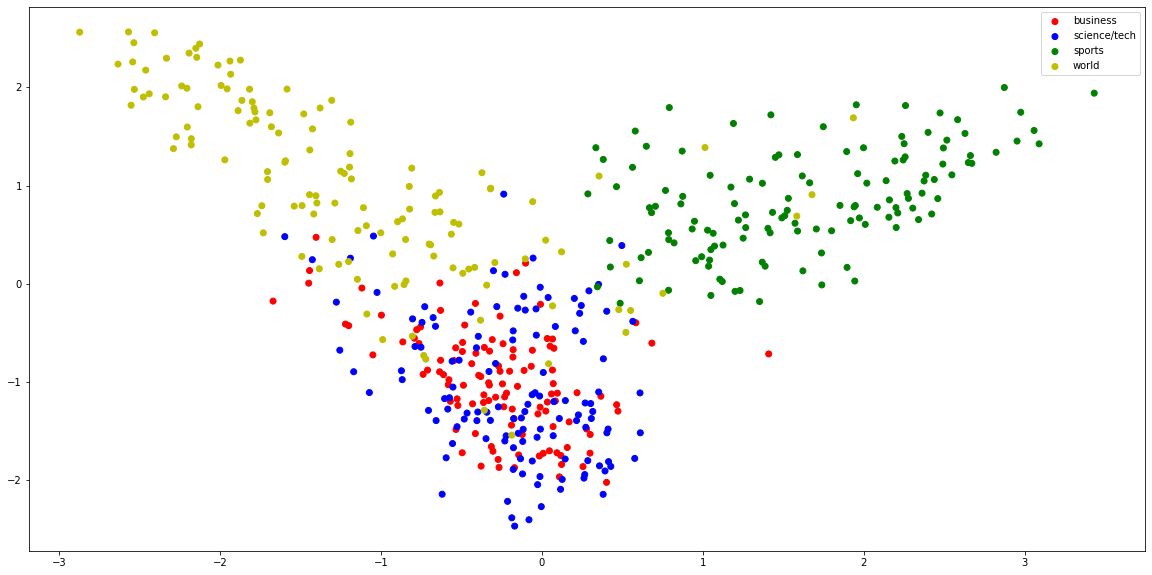

In [39]:

plt.figure(figsize=(20, 10))
colors = ["r", "b", "g", "y"]
for l in labels:
    vectors_to_plot = [reduced_vectors[i] for i in range(len(test_samples)) if test_samples[i].label == l]
    plt.scatter(*zip(*vectors_to_plot), c=[colors[list(labels).index(l)]] * len(vectors_to_plot))
plt.legend(labels);

# Dimensionality reduction

In [40]:
N = 180
pca = PCA(N)
pca = pca.fit([x.vector for x in test_samples])
print("Explained variance:", sum(pca.explained_variance_ratio_))

Explained variance: 0.9614058513100171


# Classification 

In [41]:
from koala.utils import split_samples_per_label
train_data_per_label = split_samples_per_label(train_samples)

In [42]:
samples_per_label = range(2, 50, 2)
max_samples_per_label = max(samples_per_label)

Limits to the maximum samples

In [43]:
for k, v in train_data_per_label.items():
    train_data_per_label[k] = v[:max_samples_per_label]

In [44]:
for k, v in train_data_per_label.items():
    print(k, ": ", v[0].text)

sports :  Shaq leaves Collier with a souvenir in Heat #39;s win Miami - The Atlanta Hawks got their first look at Shaquille O #39;Neal in a Miami Heat uniform Monday night as he cut through them like a human blowtorch.
science/tech :  Google to scan books from big libraries Taking a trip to the library may take little more than a computer #39;s Web browser. Working with major libraries, Google is hoping to scan millions of books and periodicals into its popular 
world :  Two Afghanistan Hostages Call Home (AP) AP - A Kosovar woman among three U.N. workers kidnapped in Afghanistan has called home to say she is well and expects to be freed soon, a businessman seeking her release said Tuesday.
business :  China Aviation Oil says chief will return to Singapore By Andrew Yeh and Francesco Guerrera in Hong Kong and Mure Dickie in Beijing. He has been in China on  quot;family matters quot; since late November but plans to return soon to answer investigators #39; inquiries, the Singapore 


Encode training data

In [45]:
for k, v in train_data_per_label.items():
    for i in tqdm(range(len(v)), desc="Encoding label " + str(k)):
        v[i].encode(encoder, keep_vector=True)
    train_data_per_label[k] = v

Encoding label business: 100%|██████████| 21/21 [00:00<00:00, 32.81it/s]


In [46]:
for n in samples_per_label:
    dict_vectors_per_label = {k: [x.vector for x in v] for k, v in train_data_per_label.items()}

In [47]:

def evaluate(classificator, dataset, name_experiment=""):
    dict_results = {}
    for d in tqdm(dataset, position=0, leave=True, desc="Evaluating " + name_experiment):
        r = classificator.classify_vector(d.vector)
        prediction = sorted(r.items(), key=lambda x: x[1], reverse=True)[0][0]
        l = d.label
        x = dict_results.get(l, {"ok": 0, "total": 0, "scores": []})
        if prediction == l:
            dict_results[l] = {"ok": x["ok"] + 1, "total": x["total"] +1, "scores": x["scores"] + [r[l]]}
        else:
            dict_results[l] = {"ok": x["ok"], "total": x["total"] +1, "scores": x["scores"] + [r[l]]}
    return dict_results

In [48]:
def compute_ratio(x):
    return x["ok"]/ x["total"]

def compute_accuracy(x):
    oks = sum([v["ok"] for v in x.values()])
    totals = sum([v["total"] for v in x.values()])
    return oks/totals

## Cosine distance to center

In [49]:
from koala.few_samples_classific import DistanceToAverageClassifier

In [50]:
results_cosine_distance_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    distance_classifier = DistanceToAverageClassifier("cosine", True)
    distance_classifier.fit(dict_sampled)
    results_cosine_distance_classifier[n] = evaluate(distance_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 500/500 [00:00<00:00, 1150.49it/s]


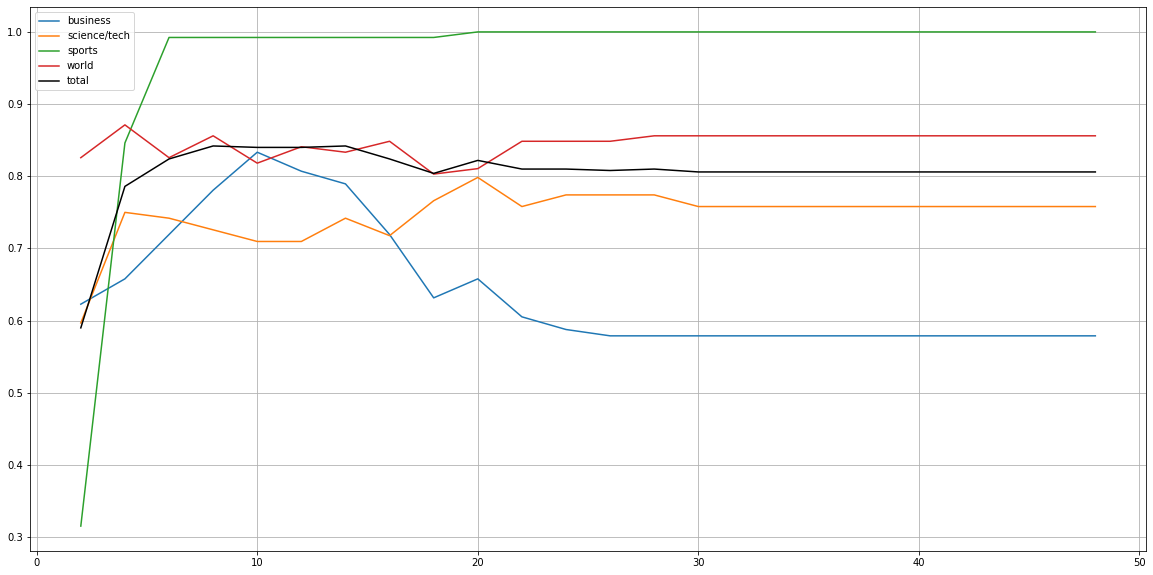

In [51]:
plt.figure(figsize=(20, 10))

        
    
for i in labels:
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
    
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_cosine_distance_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.show()

## With K-neighbors

In [53]:
from koala.few_samples_classific import NeighborsClassifier

In [54]:
results_neighsbour_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    neighbors_classifier = NeighborsClassifier()
    neighbors_classifier.fit(dict_sampled)
    results_neighsbour_classifier[n] = evaluate(neighbors_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 500/500 [00:00<00:00, 548.05it/s]


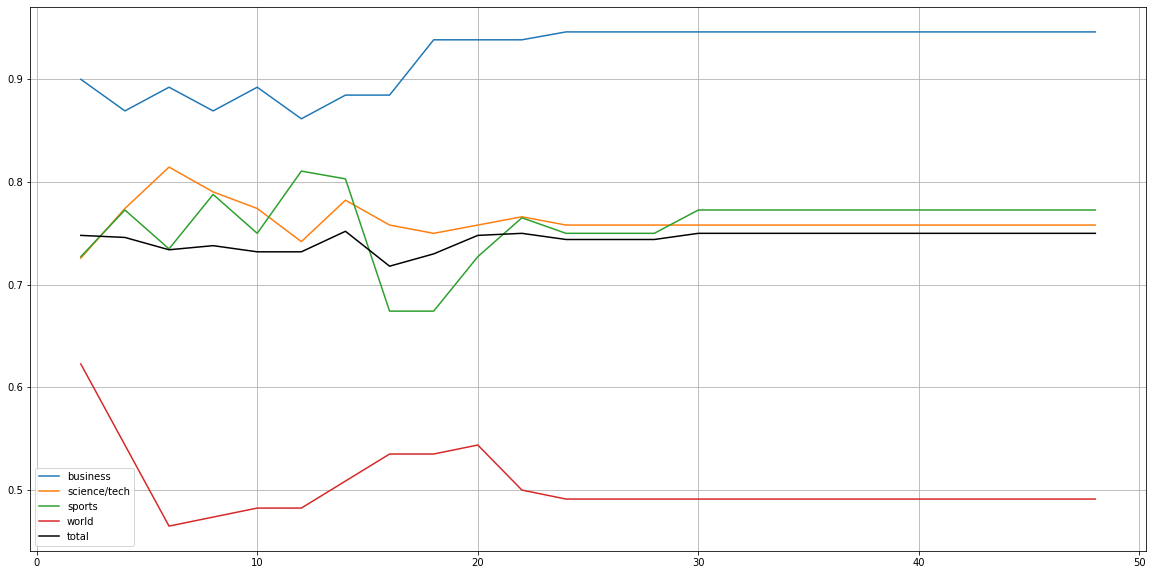

In [55]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_neighsbour_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.show()

 ## Similarity Classifier (Logistic)

In [60]:
from koala.few_samples_classific import SimilarityClassifier

In [63]:
results_similarity_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    similarity_classifier = SimilarityClassifier()
    similarity_classifier.fit(dict_sampled)
    results_similarity_classifier[n] = evaluate(similarity_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 500/500 [00:01<00:00, 453.18it/s]


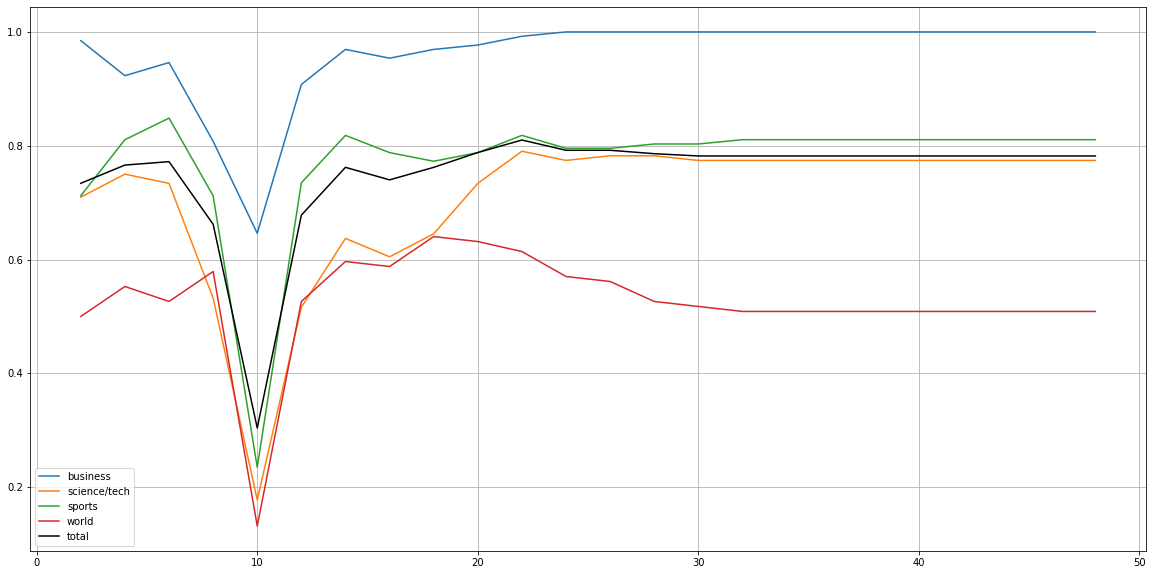

In [64]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Similarity Classifier (Dense)

In [66]:
from koala.few_samples_classific import SimilarityClassifier

In [67]:
results_similarity_classifier_dense = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    similarity_classifier = SimilarityClassifier("dense", pca)
    similarity_classifier.fit(dict_sampled)
    results_similarity_classifier_dense[n] = evaluate(similarity_classifier, test_samples, str(n) + " samples per label")

Evaluating 38 samples per label:  11%|█         | 56/500 [00:05<00:46,  9.57it/s]


KeyboardInterrupt: 

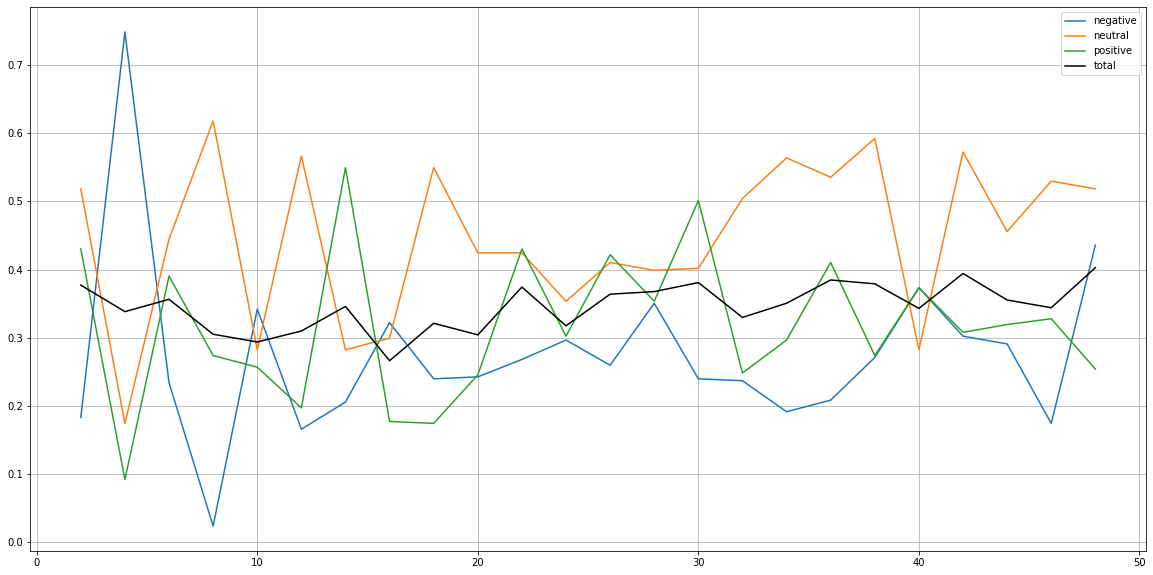

In [72]:
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier_dense.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier_dense.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Siamese network

In [57]:
from koala.few_samples_classific import SiameseNetworkClassifier

In [58]:
results_siamese_classifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    siamese_classifier = SiameseNetworkClassifier(pca)
    siamese_classifier.fit(dict_sampled)
    results_siamese_classifier[n] = evaluate(siamese_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 1053/1053 [00:48<00:00, 21.68it/s]


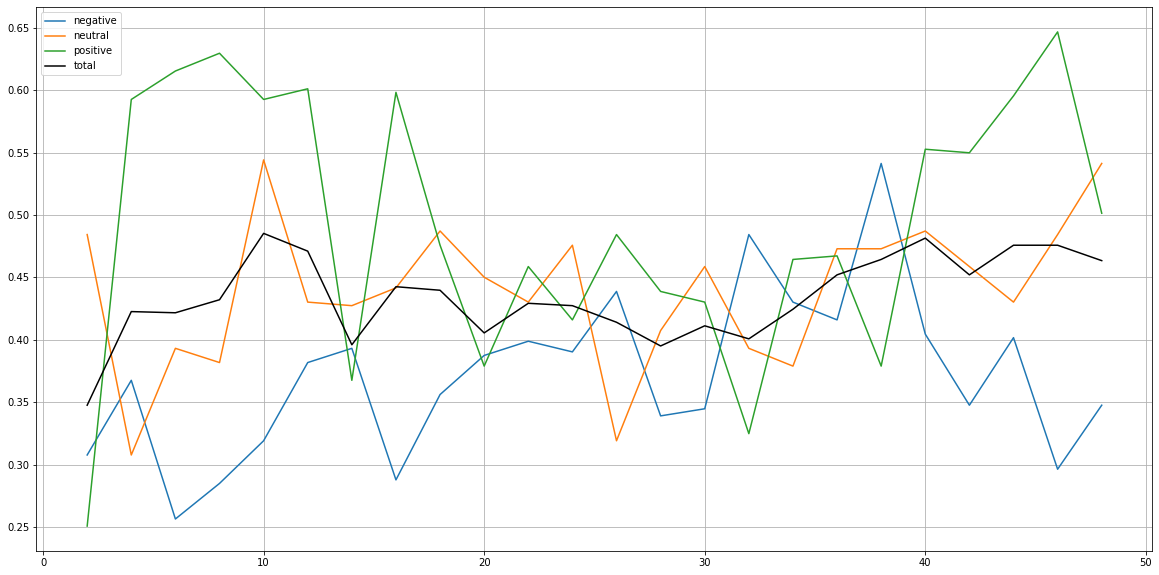

In [59]:
plt.figure(figsize=(20, 10))

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_siamese_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_siamese_classifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)

## Comparation of graphs

In [ ]:
legend_titles = []
colors = ["r", "b", "g", "y"]
plt.figure(figsize=(20, 10))
for idx, i in enumerate(dict_sampled.keys()):
        
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("distance_cosine_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="x")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_cosine_distance_classifier.items()])
    plt.plot(x, y, c="k", marker="x")
    legend_titles.append("distance_cosine_total")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("neighbours_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="o")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_neighsbour_classifier.items()])
    plt.plot(x, y, c="k", marker="o")
    legend_titles.append("distance_neighsbour")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_similarity_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("similarity_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="s")
    
    x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_similarity_classifier.items()])
    plt.plot(x, y, c="k", marker="s")
    legend_titles.append("distance_similarity_total")
    
plt.legend(legend_titles)
plt.grid(True)

## Merge of classifiers

In [65]:
from koala.classifier import MultiClassifier

In [66]:
results_muticlassifier = {}
for n in samples_per_label:
    dict_sampled = {k: v[:n] for k, v in dict_vectors_per_label.items()}
    neighbors_classifier = MultiClassifier()
    neighbors_classifier.fit(dict_sampled)
    results_muticlassifier[n] = evaluate(neighbors_classifier, test_samples, str(n) + " samples per label")

Evaluating 48 samples per label: 100%|██████████| 7600/7600 [00:21<00:00, 345.57it/s]


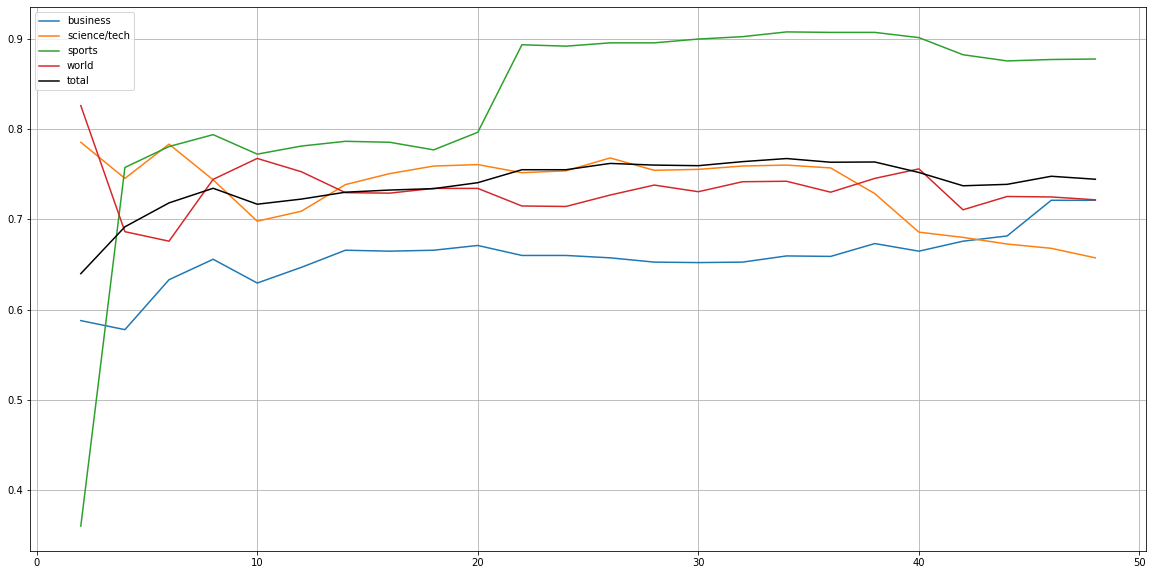

In [67]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
def compute_ratio(x):
    return x["ok"]/ x["total"]

for i in dict_sampled.keys():
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_muticlassifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples

    plt.plot(x, y)
    

x, y = zip(*[(k, compute_accuracy(v)) for k, v in results_muticlassifier.items()])
plt.plot(x, y, c="k")

plt.legend(list(labels) + ["total"])
plt.grid(True)
plt.grid(True)
plt.show()

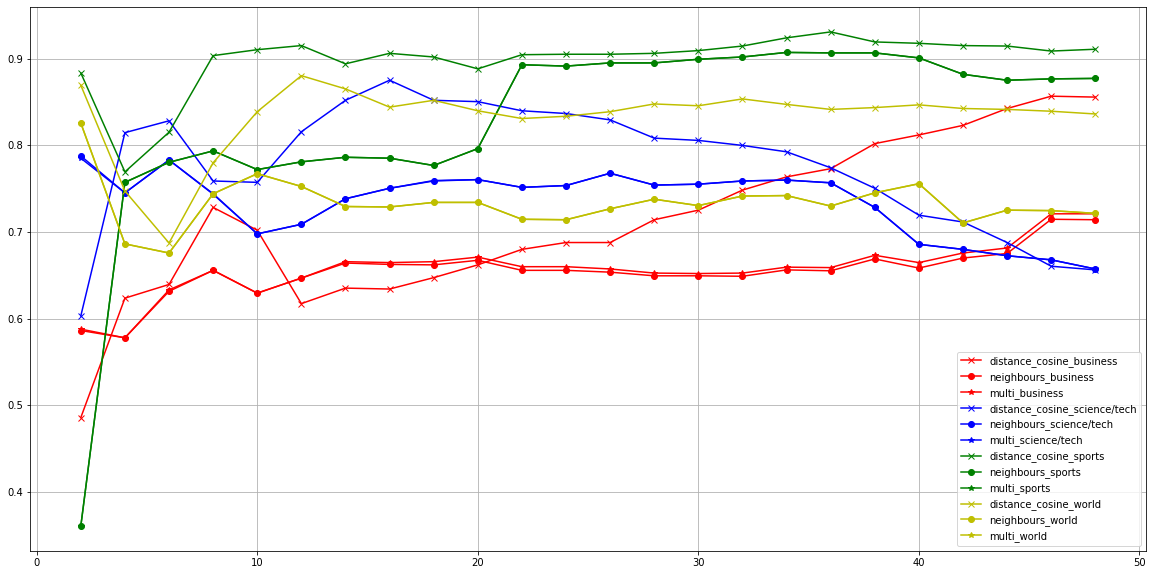

In [68]:
legend_titles = []
colors = ["r", "b", "g", "y"]
plt.figure(figsize=(20, 10))
for idx, i in enumerate(dict_sampled.keys()):
        
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_cosine_distance_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("distance_cosine_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="x")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_neighsbour_classifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("neighbours_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="o")
    
    r_i = sorted([(number_samples, compute_ratio(v[i])) for number_samples, v in results_muticlassifier.items()], key=lambda x: x[0])
    x, y = zip(*r_i) # unpack a list of pairs into two tuples
    legend_titles.append("multi_" + str(i))
    plt.plot(x, y, c=colors[idx], marker="*")
    

    
plt.legend(legend_titles)
plt.grid(True)